# LIBRARIES

In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    SHConfig, 
    SentinelHubCatalog, 
    filter_times,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions
)

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# FUNCTIONS

In [2]:
def plot_image(image, factor=3.5/255, clip_range=(0,1)):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image['array'] * factor, *clip_range))
    else:
        ax.imshow(image['array'] * factor)
    ax.set_title(image['timestamp'], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

In [3]:
def get_true_color_request(time_interval, evalscript, coi, aoi_bbox, aoi_size, maxcc, config):
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=coi,
                time_interval=time_interval,
                maxcc = maxcc
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=aoi_bbox,
        size=aoi_size,
        config=config,
    )

# CREDENTIALS

In [6]:
config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret or not config.instance_id:
    config.sh_client_id = '<ENTER_YOUR_client_id>'
    config.sh_client_secret = '<ENTER_YOUR_PERSONAL_client_secret>'
    config.instance_id = '<ENTER_YOUR_instance_id>'

# COLLECTION

In [4]:
coi = DataCollection.SENTINEL2_L1C
coi

<DataCollection.SENTINEL2_L1C: DataCollectionDefinition(
  api_id: sentinel-2-l1c
  catalog_id: sentinel-2-l1c
  wfs_id: DSS1
  service_url: https://services.sentinel-hub.com
  collection_type: Sentinel-2
  sensor_type: MSI
  processing_level: L1C
  bands: (Band(name='B01', units=(<Unit.REFLECTANCE: 'REFLECTANCE'>, <Unit.DN: 'DN'>), output_types=(<class 'numpy.float32'>, <class 'numpy.uint16'>)), Band(name='B02', units=(<Unit.REFLECTANCE: 'REFLECTANCE'>, <Unit.DN: 'DN'>), output_types=(<class 'numpy.float32'>, <class 'numpy.uint16'>)), Band(name='B03', units=(<Unit.REFLECTANCE: 'REFLECTANCE'>, <Unit.DN: 'DN'>), output_types=(<class 'numpy.float32'>, <class 'numpy.uint16'>)), Band(name='B04', units=(<Unit.REFLECTANCE: 'REFLECTANCE'>, <Unit.DN: 'DN'>), output_types=(<class 'numpy.float32'>, <class 'numpy.uint16'>)), Band(name='B05', units=(<Unit.REFLECTANCE: 'REFLECTANCE'>, <Unit.DN: 'DN'>), output_types=(<class 'numpy.float32'>, <class 'numpy.uint16'>)), Band(name='B06', units=(<Unit.RE

In [5]:
coi_evalscript = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

# AREA, TIME AND CLOUD COVERAGE OF INTEREST

In [7]:
maxcc = 0.5 #max cloud coverage

In [8]:
resolution = 35
aoi_coords_wgs84 = (25.701319,40.901564,26.707254,41.291725)
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")

Image shape at 40 m resolution: (2122, 1064) pixels


In [9]:
toi_ini, toi_end = "2023-08-01", "2023-09-01"
time_interval = (toi_ini, toi_end)
time_interval

('2023-08-01', '2023-09-01')

# SEARCH

In [10]:
catalog = SentinelHubCatalog(config=config)
search_iterator = catalog.search(
    coi,
    bbox=aoi_bbox,
    time=time_interval,
    filter="eo:cloud_cover < %s"%(maxcc),
)

In [11]:
timestamps = search_iterator.get_timestamps()
timestamps_str = [dt.strftime("%Y-%m-%dT%H:%M:%SZ") for dt in timestamps]
print("Total number of results:", len(timestamps_str))
print(sorted(timestamps_str))

Total number of results: 8
['2023-08-03T09:19:08Z', '2023-08-05T09:09:07Z', '2023-08-23T09:18:59Z', '2023-08-23T09:19:09Z', '2023-08-25T09:09:07Z', '2023-08-28T09:19:03Z', '2023-08-28T09:19:07Z', '2023-08-30T09:09:08Z']


In [12]:
timestamps_str = [dt.strftime("%Y-%m-%dT%H:%M:%SZ") for dt in filter_times(timestamps, datetime.timedelta(hours=1) )]
print("Total number of unique results:", len(timestamps_str))
print(sorted(timestamps_str))

Total number of unique results: 6
['2023-08-03T09:19:08Z', '2023-08-05T09:09:07Z', '2023-08-23T09:18:59Z', '2023-08-25T09:09:07Z', '2023-08-28T09:19:03Z', '2023-08-30T09:09:08Z']


# REQUEST

In [13]:
images = []
for dt in timestamps_str:
    request_true_color = get_true_color_request( (dt,dt), coi_evalscript, coi, aoi_bbox, aoi_size, maxcc, config)
    true_color_imgs = request_true_color.get_data()
    print(f"shape {true_color_imgs[0].shape}")
    image = {'array': true_color_imgs[0], 'timestamp': dt }
    images.append(image)

shape (1064, 2122, 3)
shape (1064, 2122, 3)
shape (1064, 2122, 3)
shape (1064, 2122, 3)
shape (1064, 2122, 3)
shape (1064, 2122, 3)


# PREVIEW

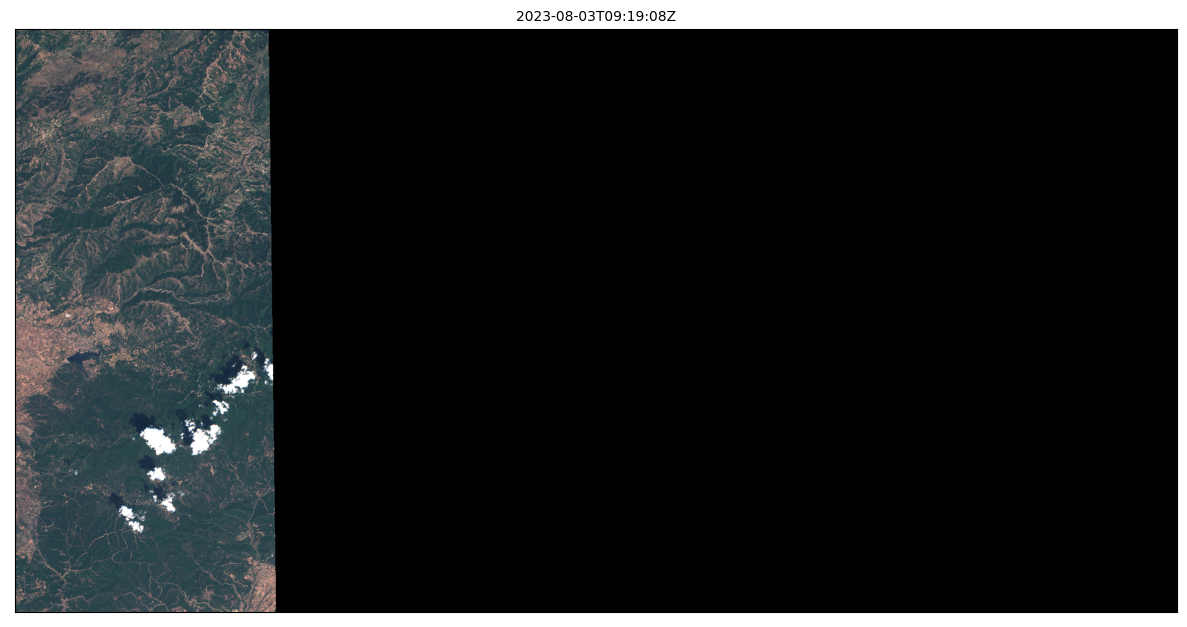

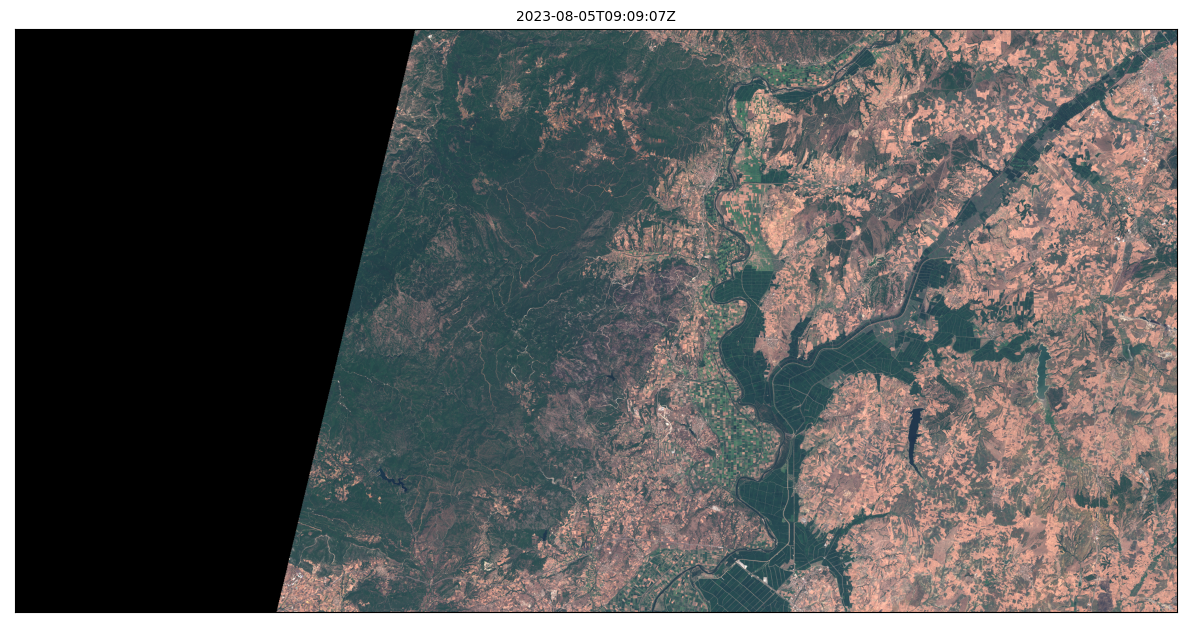

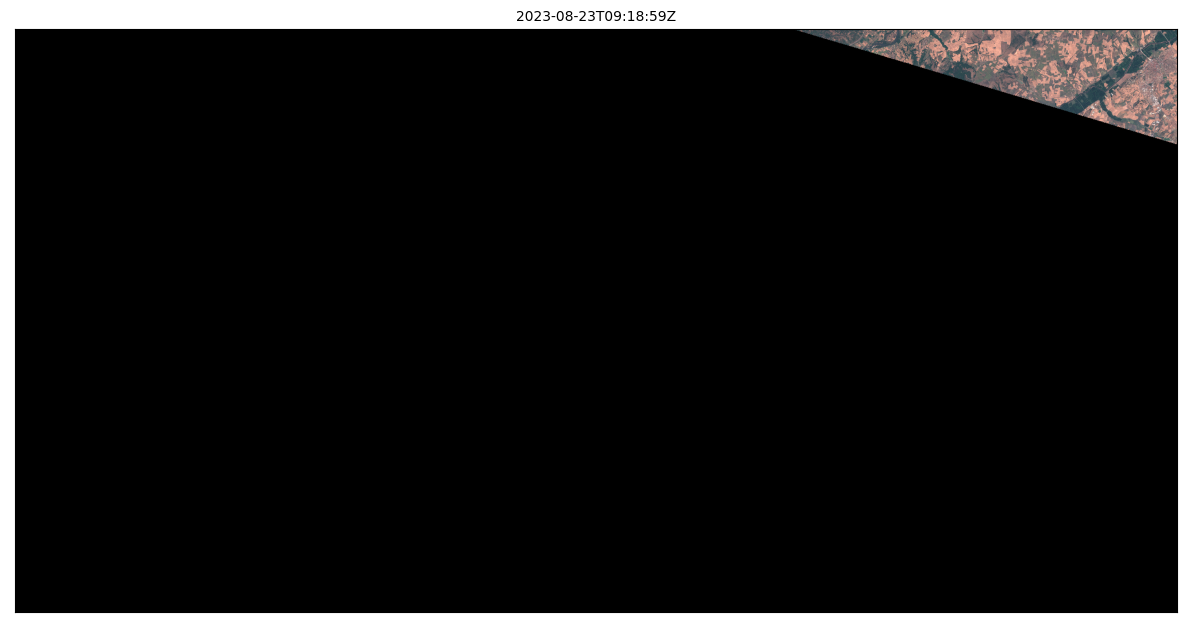

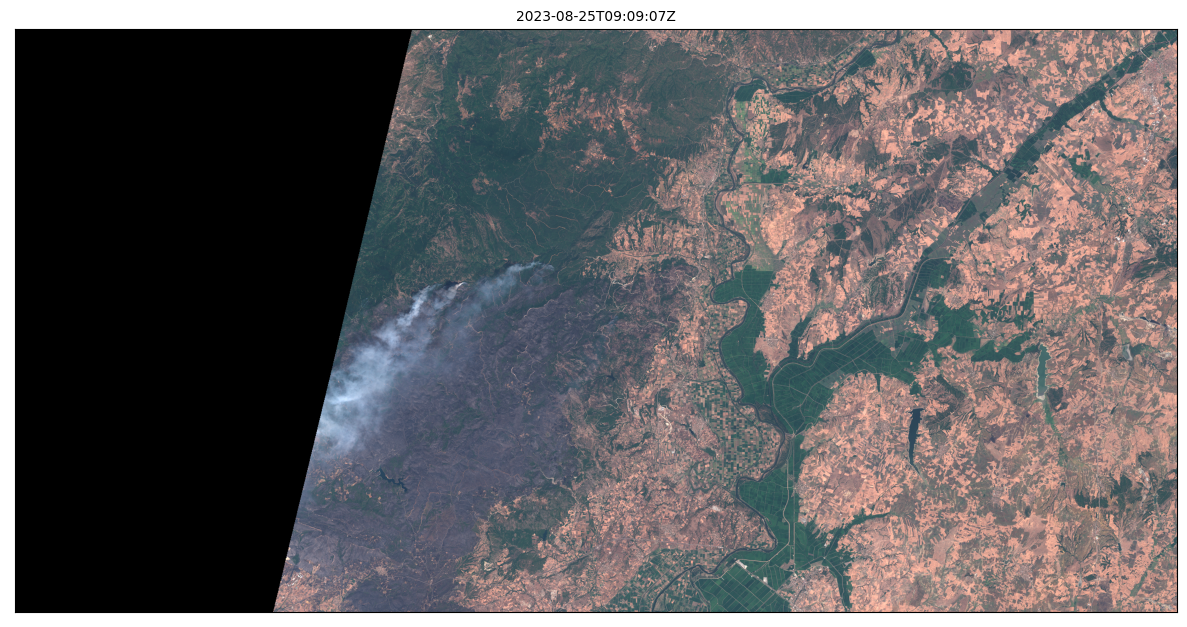

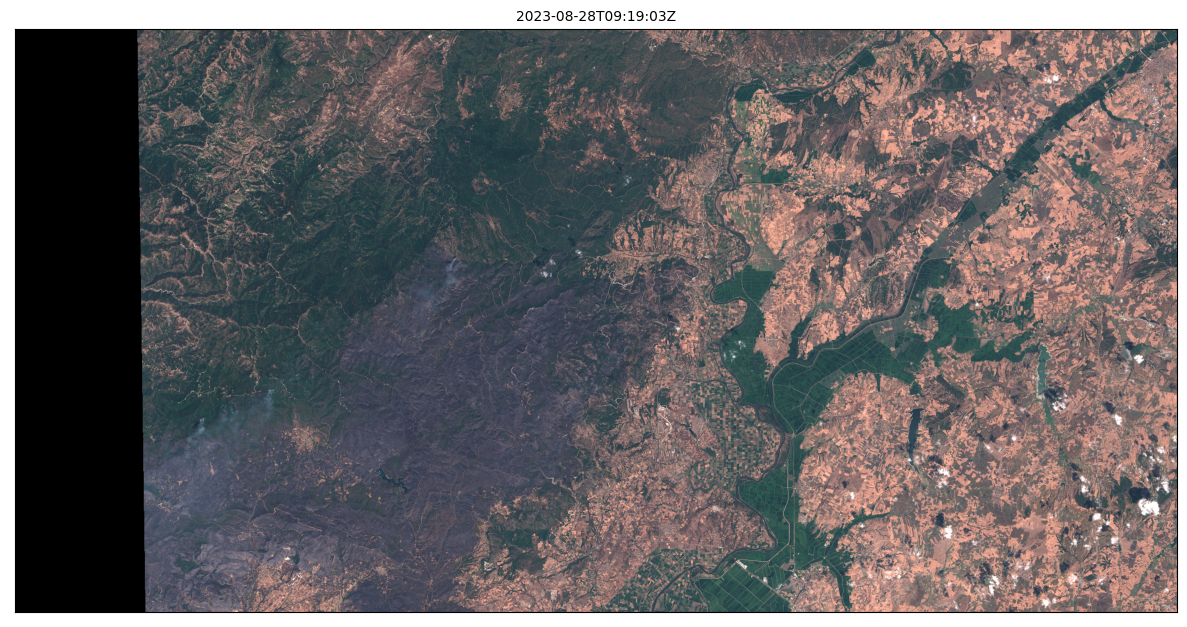

In [14]:
for i in range(0, len(images)):
    plot_image(images[i], factor=3.5 / 255)
    # plot function
    # factor 1/255 to scale between 0-1
    # factor 3.5 to increase brightness